In [1]:
import os
import rioxarray as rxr
from rasterstats import point_query
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_squared_error
# Set the font size and style
plt.rcParams.update({'font.size': 16, 'font.family': 'Helvetica'})

In [2]:
def snowDEM_val(snowOnDEM_path, snowFreeDEM_path, veg_path, slope_path, asp_path, csv_path, snowdepth_col, lat_col, lon_col, csv_EPSG=4326, zone_utmcrs=32611, lid_unit="m", probe_unit="cm", veg_unit = "m"):

    #read the rasters
    snow_on_dem = rxr.open_rasterio(snowOnDEM_path, masked =True)
    snow_ref_dem = rxr.open_rasterio(snowFreeDEM_path, masked=True)
    # Get the extent of the UAV_SD raster
    uav_extent = snow_on_dem.rio.bounds()
    # Clip the other datasets to the extent of UAV_SD
    snow_ref_dem = snow_ref_dem.rio.clip_box(*uav_extent)

    # Reproject snoow off raster to match the snow-off dem
    snow_on_dem_reproj = snow_on_dem.rio.reproject_match(snow_ref_dem)
    #Difference
    snowDepth = snow_on_dem_reproj - snow_ref_dem
    #reproject to crs of the zone
    if snowDepth.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        snowDepth = snowDepth.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))
    #read the snow-off vegetation data
    veg = rxr.open_rasterio(veg_path, masked = True)
    #reproject to crs of the zone
    if veg.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        veg = veg.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))
    #read the slope data
    slope = rxr.open_rasterio(slope_path, masked = True)
    #reproject to crs of the zone
    if slope.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        slope = slope.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))
    #read the aspect data
    asp = rxr.open_rasterio(asp_path, masked = True)
    #reproject to crs of the zone
    if asp.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        asp = asp.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))

     # read the csv
    df = pd.read_csv(csv_path, usecols=[snowdepth_col, lat_col, lon_col])

    # convert to geodataframe
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs="EPSG:" + str(csv_EPSG),
    )
    # convert the gdf to crs of the zone
    gdf_utm = gdf.to_crs("EPSG:" + str(zone_utmcrs))

    # sample the snow depth raster values at point locations
    vals = point_query(gdf_utm.geometry, snowDepth.squeeze().values, affine = snowDepth.rio.transform(), nodata = -9999)
    # add the values to a new column in the GeoDataFrame
    gdf_utm['snowDepth'] = vals    
    # sample the snow-off vegetation raster values at point locations
    veg_vals = point_query(gdf_utm.geometry, veg.squeeze().values, affine = veg.rio.transform(), nodata = -9999)
    # add the values to a new column in the GeoDataFrame
    gdf_utm['snow-off veg'] = veg_vals
    # sample slope and aspect at point locations
    slope_vals = point_query(gdf_utm.geometry, slope.squeeze().values, affine = slope.rio.transform(), nodata = -9999)
    asp_vals = point_query(gdf_utm.geometry, asp.squeeze().values, affine = asp.rio.transform(), nodata = -9999)
    # add the values to a new column in the GeoDataFrame
    gdf_utm['slope'] = slope_vals
    gdf_utm['aspect'] = asp_vals

    #convert the unit to m
    if probe_unit == "cm":
        gdf_utm[snowdepth_col] = gdf_utm[snowdepth_col] / 100
    if lid_unit == "cm":
        gdf_utm["snowDepth"] = gdf_utm["snowDepth"]/100
    if veg_unit == "cm":
        gdf_utm["snow-off veg"] = gdf_utm["snow-off veg"]/100
    gdf_utm.rename(columns={
                       snowdepth_col: 'probed snow depth', 'snowDepth': 'snow depth'}, inplace=True)
    #drop missing values because mean_squared_error won't allow nan
    gdf_utm = gdf_utm.dropna(subset=['probed snow depth', 'snow depth'])


    # define the custom ranges for the vegetation values
    ranges = [0, 0.2, 2, 100]
    # use the cut function to group values into custom ranges
    gdf_utm['vegetation class'] = pd.cut(gdf_utm['snow-off veg'], bins=ranges,
                     labels=['sparse (0-0.2m)', 'medium (0.2 -2m)', 'dense(>2m)'])

    #add error column
    gdf_utm['error (cm)'] = (gdf_utm['probed snow depth'] - gdf_utm['snow depth']) * 100
    #absolute error column
    gdf_utm['abs_err (cm)'] = np.abs(gdf_utm['error (cm)'])

    # Set up the plotting environment
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    #Plot the snowdepth vs probed data
    sns.regplot(x='probed snow depth', y='snow depth', data=gdf_utm, ax=axs[0])
    corr = np.corrcoef(gdf_utm['probed snow depth'], gdf_utm['snow depth'])[0, 1]
    mse = mean_squared_error(gdf_utm['probed snow depth'], gdf_utm['snow depth'])
    rmse = np.sqrt(mse)
    nmad = 1.4826 * np.median(np.abs(gdf_utm['probed snow depth'] - gdf_utm['snow depth']))
    text = f'r = {corr:.2f}\nRMSE = {rmse:.2f}m\nNMAD = {nmad:.2f}m'
    axs[0].text(0.01, 0.98, text, transform=axs[0].transAxes, ha='left', va='top')
    axs[0].set_xlabel('Probed Snow Depth (m)')
    axs[0].set_ylabel('SFM Snow Depth (m)')

    # Plot the distribution of errors
    sns.histplot(gdf_utm['error (cm)'], kde=True, bins=30, ax = axs[1])

    # Add title and labels
    axs[1].set_xlabel('Error (cm)')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)

    plt.show()

    return gdf_utm

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


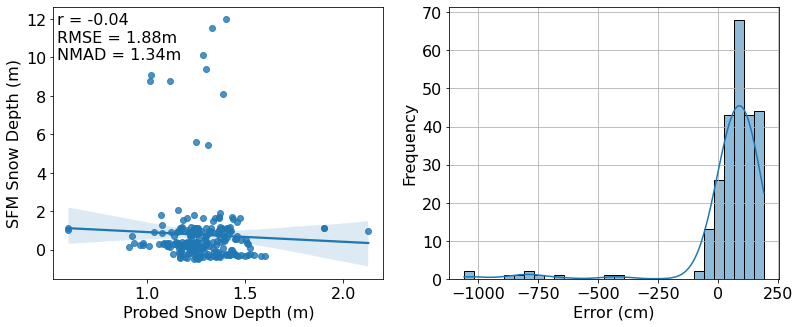

In [4]:
snowOnDEM_path = "/SNOWDATA/IDALS/2024/20231221/20231221_MCS_UAV/SfM/2023-12-22_MCS_DTM_UTM11N_0.5m_v2.tif"
snowFreeDEM_path = "/SNOWDATA/IDALS/misc_data_scripts/dem.tif"
veg_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/vh.tif"
slope_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/slope.tif"
asp_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/aspect.tif"
csv_path = "/SNOWDATA/IDALS/2024/20231221/CR800Series_OperatorViewCSV_OldGPS_V2.csv"
snowdepth_col = "DepthCm"
lat_col = "lat"
lon_col = "lon"

val_df = snowDEM_val(snowOnDEM_path, snowFreeDEM_path, veg_path, slope_path, asp_path, csv_path, snowdepth_col, lat_col, lon_col, csv_EPSG=4326, zone_utmcrs=32611, lid_unit="m", probe_unit="cm", veg_unit = "m")

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


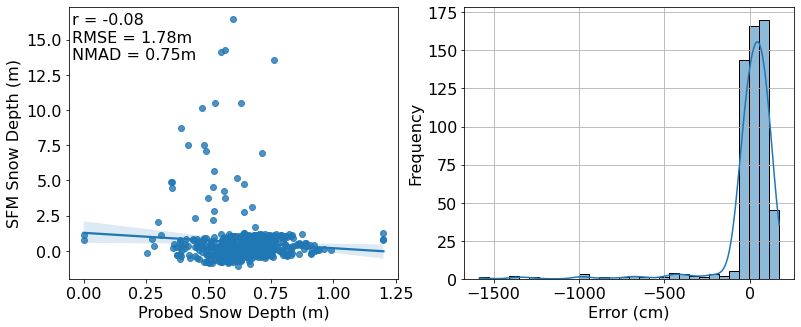

In [3]:
snowOnDEM_path = "/SNOWDATA/IDALS/2024/20231221/20231221_MCS_UAV/SfM/2023-12-22_MCS_DTM_UTM11N_0.5m_v2.tif"
snowFreeDEM_path = "/SNOWDATA/IDALS/misc_data_scripts/dem.tif"
veg_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/vh.tif"
slope_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/slope.tif"
asp_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/aspect.tif"
csv_path = "/SNOWDATA/IDALS/2024/20231221/CR800Series_OperatorViewCSV.csv"
snowdepth_col = "DepthCm"
lat_col = "lat"
lon_col = "lon"

val_df = snowDEM_val(snowOnDEM_path, snowFreeDEM_path, veg_path, slope_path, asp_path, csv_path, snowdepth_col, lat_col, lon_col, csv_EPSG=4326, zone_utmcrs=32611, lid_unit="m", probe_unit="cm", veg_unit = "m")

In [4]:
def snowDepth_val(snowDepth_path, veg_path, slope_path, asp_path, csv_path, snowdepth_col, lat_col, lon_col, csv_EPSG=4326, zone_utmcrs=32611, lid_unit="m", probe_unit="cm", veg_unit = "m"):

    snowDepth = rxr.open_rasterio(snowDepth_path, masked = True)
    #reproject to crs of the zone
    if snowDepth.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        snowDepth = snowDepth.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))
    #read the snow-off vegetation data
    veg = rxr.open_rasterio(veg_path, masked = True)
    #reproject to crs of the zone
    if veg.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        veg = veg.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))
    #read the slope data
    slope = rxr.open_rasterio(slope_path, masked = True)
    #reproject to crs of the zone
    if slope.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        slope = slope.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))
    #read the aspect data
    asp = rxr.open_rasterio(asp_path, masked = True)
    #reproject to crs of the zone
    if asp.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        asp = asp.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))

     # read the csv
    df = pd.read_csv(csv_path, usecols=[snowdepth_col, lat_col, lon_col])

    # convert to geodataframe
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs="EPSG:" + str(csv_EPSG),
    )
    # convert the gdf to crs of the zone
    gdf_utm = gdf.to_crs("EPSG:" + str(zone_utmcrs))

    # sample the snow depth raster values at point locations
    vals = point_query(gdf_utm.geometry, snowDepth.squeeze().values, affine = snowDepth.rio.transform(), nodata = -9999)
    # add the values to a new column in the GeoDataFrame
    gdf_utm['snowDepth'] = vals    
    # sample the snow-off vegetation raster values at point locations
    veg_vals = point_query(gdf_utm.geometry, veg.squeeze().values, affine = veg.rio.transform(), nodata = -9999)
    # add the values to a new column in the GeoDataFrame
    gdf_utm['snow-off veg'] = veg_vals
    # sample slope and aspect at point locations
    slope_vals = point_query(gdf_utm.geometry, slope.squeeze().values, affine = slope.rio.transform(), nodata = -9999)
    asp_vals = point_query(gdf_utm.geometry, asp.squeeze().values, affine = asp.rio.transform(), nodata = -9999)
    # add the values to a new column in the GeoDataFrame
    gdf_utm['slope'] = slope_vals
    gdf_utm['aspect'] = asp_vals

    #convert the unit to m
    if probe_unit == "cm":
        gdf_utm[snowdepth_col] = gdf_utm[snowdepth_col] / 100
    if lid_unit == "cm":
        gdf_utm["snowDepth"] = gdf_utm["snowDepth"]/100
    if veg_unit == "cm":
        gdf_utm["snow-off veg"] = gdf_utm["snow-off veg"]/100
    gdf_utm.rename(columns={
                       snowdepth_col: 'probed snow depth', 'snowDepth': 'snow depth'}, inplace=True)
    #drop missing values because mean_squared_error won't allow nan
    gdf_utm = gdf_utm.dropna(subset=['probed snow depth', 'snow depth'])


    # define the custom ranges for the vegetation values
    ranges = [0, 0.2, 2, 100]
    # use the cut function to group values into custom ranges
    gdf_utm['vegetation class'] = pd.cut(gdf_utm['snow-off veg'], bins=ranges,
                     labels=['sparse (0-0.2m)', 'medium (0.2 -2m)', 'dense(>2m)'])

    #add error column
    gdf_utm['error (cm)'] = (gdf_utm['probed snow depth'] - gdf_utm['snow depth']) * 100
    #absolute error column
    gdf_utm['abs_err (cm)'] = np.abs(gdf_utm['error (cm)'])

    # Set up the plotting environment
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    #Plot the snowdepth vs probed data
    sns.regplot(x='probed snow depth', y='snow depth', data=gdf_utm, ax=axs[0])
    corr = np.corrcoef(gdf_utm['probed snow depth'], gdf_utm['snow depth'])[0, 1]
    mse = mean_squared_error(gdf_utm['probed snow depth'], gdf_utm['snow depth'])
    rmse = np.sqrt(mse)
    nmad = 1.4826 * np.median(np.abs(gdf_utm['probed snow depth'] - gdf_utm['snow depth']))
    text = f'r = {corr:.2f}\nRMSE = {rmse:.2f}m\nNMAD = {nmad:.2f}m'
    axs[0].text(0.01, 0.98, text, transform=axs[0].transAxes, ha='left', va='top')
    axs[0].set_xlabel('Probed Snow Depth (m)')
    axs[0].set_ylabel('LiDAR Snow Depth (m)')

    # Plot the distribution of errors
    sns.histplot(gdf_utm['error (cm)'], kde=True, bins=30, ax = axs[1])

    # Add title and labels
    axs[1].set_xlabel('Error (cm)')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)

    plt.show()

    return gdf_utm

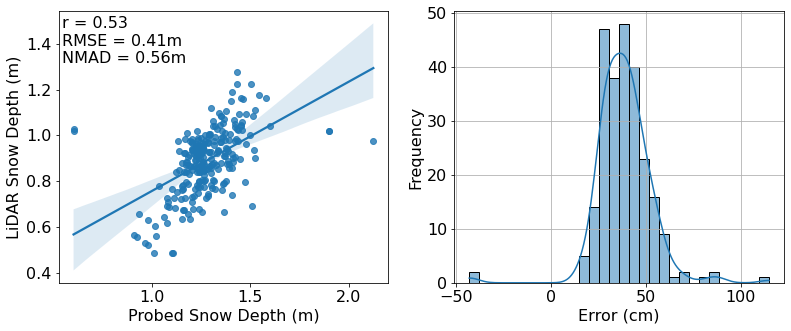

In [10]:
snowDepth_path = "/SNOWDATA/IDALS/2024/20231228/20231228_MCS/ice-road/20231228_MCS-snowdepth.tif"
veg_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/vh.tif"
slope_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/slope.tif"
asp_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/aspect.tif"
csv_path = "/SNOWDATA/IDALS/2024/20231221/CR800Series_OperatorViewCSV_OldGPS_V2.csv"
snowdepth_col = "DepthCm"
lat_col = "lat"
lon_col = "lon"

val_df = snowDepth_val(snowDepth_path, veg_path, slope_path, asp_path, csv_path, snowdepth_col, lat_col, lon_col, csv_EPSG=4326, zone_utmcrs=32611, lid_unit="m", probe_unit="cm", veg_unit = "m")

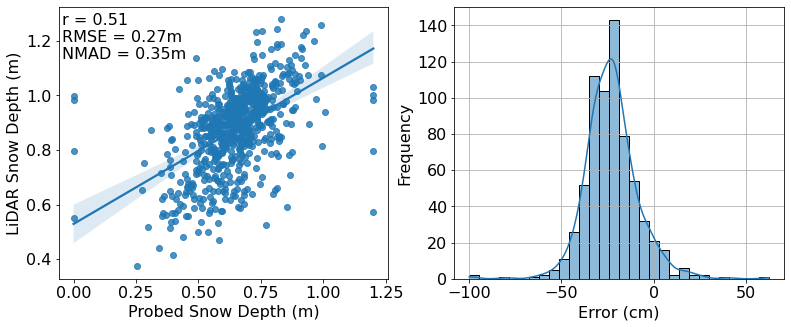

In [12]:
snowDepth_path = "/SNOWDATA/IDALS/2024/20231228/20231228_MCS/ice-road/20231228_MCS-snowdepth.tif"
veg_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/vh.tif"
slope_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/slope.tif"
asp_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/aspect.tif"
csv_path = "/SNOWDATA/IDALS/2024/20231221/CR800Series_OperatorViewCSV_correctedv2.csv"
snowdepth_col = "DepthCm"
lat_col = "latitude(deg)"
lon_col = "longitude(deg)"

val_df = snowDepth_val(snowDepth_path, veg_path, slope_path, asp_path, csv_path, snowdepth_col, lat_col, lon_col, csv_EPSG=4326, zone_utmcrs=32611, lid_unit="m", probe_unit="cm", veg_unit = "m")

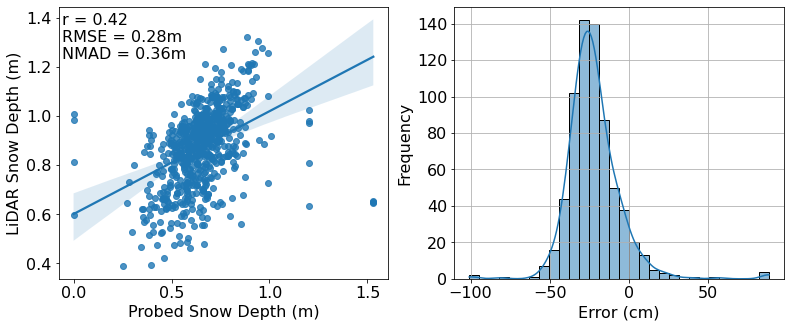

In [5]:
snowDepth_path = "/SNOWDATA/IDALS/2024/20231228/20231228_MCS/ice-road/20231228_MCS-snowdepth.tif"
veg_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/vh.tif"
slope_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/slope.tif"
asp_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/aspect.tif"
csv_path = "/SNOWDATA/IDALS/2024/20231221/CR800Series_OperatorViewCSV.csv"
snowdepth_col = "DepthCm"
lat_col = "lat"
lon_col = "lon"

val_df = snowDepth_val(snowDepth_path, veg_path, slope_path, asp_path, csv_path, snowdepth_col, lat_col, lon_col, csv_EPSG=4326, zone_utmcrs=32611, lid_unit="m", probe_unit="cm", veg_unit = "m")

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


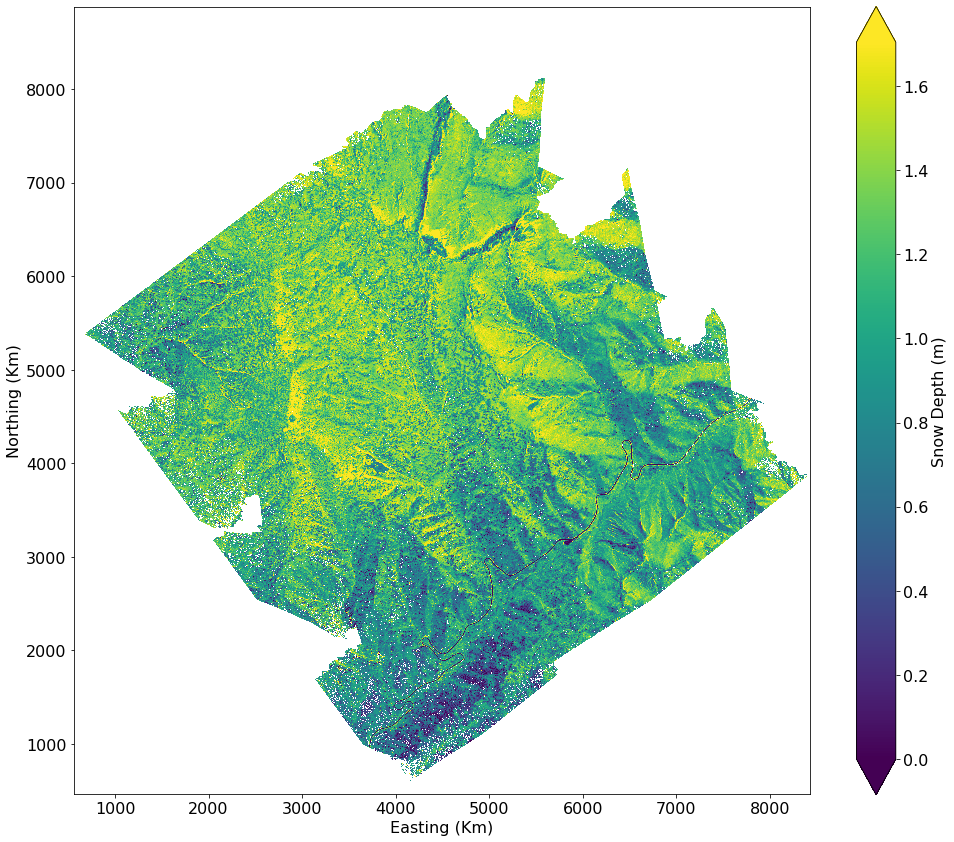

In [2]:
snowdepth = rxr.open_rasterio("/SNOWDATA/IDALS/2024/20240115/20240115_MCS/ice-road/20240115_MCS-snowdepth.tif", masked = True)
fig, ax = plt.subplots( figsize=(14, 12))
im = snowdepth.plot(ax=ax, cmap= 'viridis', robust = True, cbar_kwargs={'label': 'Snow Depth (m)'}, vmin = 0)

ax.set_title('')
ax.set_aspect('equal')
ax.set_xlabel('Easting (Km)')
ax.set_ylabel('Northing (Km)')
# Format x and y-axis labels to subtract leading digits
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x - 4.862e6)}"))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x - 601000)}"))
plt.tight_layout()
plt.show()

This validation function implements vegetation mask

In [5]:
def snowdepth_val2(snowOnDEM_path, snowFreeDEM_path, veg_path, vegMask_path, slope_path, asp_path, csv_path, snowdepth_col, lat_col, lon_col, csv_EPSG=4326, zone_utmcrs=32611, lid_unit="m", probe_unit="cm", veg_unit = "m"):

    #read the rasters
    snow_on_dem = rxr.open_rasterio(snowOnDEM_path, masked =True)
    snow_ref_dem = rxr.open_rasterio(snowFreeDEM_path, masked=True)
    veg_mask = rxr.open_rasterio(vegMask_path, masked = True)
    # Get the extent of the UAV_SD raster
    uav_extent = snow_on_dem.rio.bounds()
    # Clip the other datasets to the extent of UAV_SD
    snow_ref_dem = snow_ref_dem.rio.clip_box(*uav_extent)
    veg_mask = veg_mask.rio.clip_box(*uav_extent)
    # Reproject snoow off raster to match the snow-off dem
    snow_on_dem_reproj = snow_on_dem.rio.reproject_match(snow_ref_dem)
    #Difference
    snowDepth = snow_on_dem_reproj - snow_ref_dem
    #mask snowdepth for vegetation
    veg_mask = veg_mask.rio.reproject_match(snowDepth)
    snowDepth =snowDepth.where(veg_mask != 1)
    #reproject to crs of the zone
    if snowDepth.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        snowDepth = snowDepth.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))
    #read the snow-off vegetation data
    veg = rxr.open_rasterio(veg_path, masked = True)
    #reproject to crs of the zone
    if veg.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        veg = veg.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))
    #read the slope data
    slope = rxr.open_rasterio(slope_path, masked = True)
    #reproject to crs of the zone
    if slope.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        slope = slope.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))
    #read the aspect data
    asp = rxr.open_rasterio(asp_path, masked = True)
    #reproject to crs of the zone
    if asp.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        asp = asp.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))

     # read the csv
    df = pd.read_csv(csv_path, usecols=[snowdepth_col, lat_col, lon_col])

    # convert to geodataframe
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs="EPSG:" + str(csv_EPSG),
    )
    # convert the gdf to crs of the zone
    gdf_utm = gdf.to_crs("EPSG:" + str(zone_utmcrs))

    # sample the snow depth raster values at point locations
    vals = point_query(gdf_utm.geometry, snowDepth.squeeze().values, affine = snowDepth.rio.transform(), nodata = -9999)
    # add the values to a new column in the GeoDataFrame
    gdf_utm['snowDepth'] = vals    
    # sample the snow-off vegetation raster values at point locations
    veg_vals = point_query(gdf_utm.geometry, veg.squeeze().values, affine = veg.rio.transform(), nodata = -9999)
    # add the values to a new column in the GeoDataFrame
    gdf_utm['snow-off veg'] = veg_vals
    # sample slope and aspect at point locations
    slope_vals = point_query(gdf_utm.geometry, slope.squeeze().values, affine = slope.rio.transform(), nodata = -9999)
    asp_vals = point_query(gdf_utm.geometry, asp.squeeze().values, affine = asp.rio.transform(), nodata = -9999)
    # add the values to a new column in the GeoDataFrame
    gdf_utm['slope'] = slope_vals
    gdf_utm['aspect'] = asp_vals

    #convert the unit to m
    if probe_unit == "cm":
        gdf_utm[snowdepth_col] = gdf_utm[snowdepth_col] / 100
    if lid_unit == "cm":
        gdf_utm["snowDepth"] = gdf_utm["snowDepth"]/100
    if veg_unit == "cm":
        gdf_utm["snow-off veg"] = gdf_utm["snow-off veg"]/100
    gdf_utm.rename(columns={
                       snowdepth_col: 'probed snow depth', 'snowDepth': 'snow depth'}, inplace=True)
    #drop missing values because mean_squared_error won't allow nan
    gdf_utm = gdf_utm.dropna(subset=['probed snow depth', 'snow depth'])


    # define the custom ranges for the vegetation values
    ranges = [0, 0.2, 2, 100]
    # use the cut function to group values into custom ranges
    gdf_utm['vegetation class'] = pd.cut(gdf_utm['snow-off veg'], bins=ranges,
                     labels=['sparse (0-0.2m)', 'medium (0.2 -2m)', 'dense(>2m)'])

    #add error column
    gdf_utm['error (cm)'] = (gdf_utm['probed snow depth'] - gdf_utm['snow depth']) * 100
    #absolute error column
    gdf_utm['abs_err (cm)'] = np.abs(gdf_utm['error (cm)'])

    # Set up the plotting environment
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    #Plot the snowdepth vs probed data
    sns.regplot(x='probed snow depth', y='snow depth', data=gdf_utm, ax=axs[0])
    corr = np.corrcoef(gdf_utm['probed snow depth'], gdf_utm['snow depth'])[0, 1]
    mse = mean_squared_error(gdf_utm['probed snow depth'], gdf_utm['snow depth'])
    rmse = np.sqrt(mse)
    text = f'r = {corr:.2f}\nRMSE = {rmse:.2f}m'
    axs[0].text(0.05, 0.95, text, transform=axs[0].transAxes, ha='left', va='top')
    axs[0].set_xlabel('Probed Snow Depth (m)')
    axs[0].set_ylabel('SFM Snow Depth (m)')

    # Plot the distribution of errors
    sns.histplot(gdf_utm['error (cm)'], kde=True, bins=30, ax = axs[1])

    # Add title and labels
    axs[1].set_xlabel('Error (cm)')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)

    plt.show()

    return gdf_utm

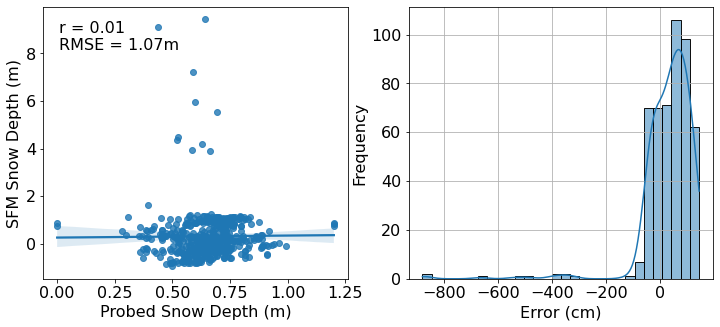

In [14]:
snowOnDEM_path = "/SNOWDATA/IDALS/2024/20231221/20231221_MCS_UAV/SfM/2023-12-22_MCS_DTM_UTM11N_0.5m_v2.tif"
snowFreeDEM_path = "/SNOWDATA/IDALS/misc_data_scripts/dem.tif"
veg_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/vh.tif"
vegMask_path = "/SNOWDATA/IDALS/misc_data_scripts/veg_mask.tif"
slope_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/slope.tif"
asp_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/aspect.tif"
csv_path = "/SNOWDATA/IDALS/2024/20231221/20231221_SnowDepths/CR800Series_OperatorViewCSV_corrected.csv"
snowdepth_col = "DepthCm"
lat_col = "latitude(deg)"
lon_col = "longitude(deg)"

val_df2 = snowdepth_val2(snowOnDEM_path, snowFreeDEM_path, veg_path, vegMask_path, slope_path, asp_path, csv_path, snowdepth_col, lat_col, lon_col, csv_EPSG=4326, zone_utmcrs=32611, lid_unit="m", probe_unit="cm", veg_unit = "m")

This validation function implements outlier filtering

In [39]:
def snowdepth_val3(snowOnDEM_path, snowFreeDEM_path, veg_path, vegMask_path, slope_path, asp_path, csv_path, snowdepth_col, lat_col, lon_col, csv_EPSG=4326, zone_utmcrs=32611, lid_unit="m", probe_unit="cm", veg_unit = "m", sd_f = 5):

    #read the rasters
    snow_on_dem = rxr.open_rasterio(snowOnDEM_path, masked =True)
    snow_ref_dem = rxr.open_rasterio(snowFreeDEM_path, masked=True)
    veg_mask = rxr.open_rasterio(vegMask_path, masked = True)
    # Get the extent of the UAV_SD raster
    uav_extent = snow_on_dem.rio.bounds()
    # Clip the other datasets to the extent of UAV_SD
    snow_ref_dem = snow_ref_dem.rio.clip_box(*uav_extent)
    veg_mask = veg_mask.rio.clip_box(*uav_extent)
    # Reproject snoow off raster to match the snow-off dem
    snow_on_dem_reproj = snow_on_dem.rio.reproject_match(snow_ref_dem)
    #Difference
    snowDepth = snow_on_dem_reproj - snow_ref_dem
    save_name = os.path.dirname(snowOnDEM_path) + '/snowdepth.tif'
    #save raster
    snowDepth.rio.to_raster(save_name)
    #mask snowdepth for vegetation
    veg_mask = veg_mask.rio.reproject_match(snowDepth)
    snowDepth =snowDepth.where(veg_mask != 1)
    save_name = os.path.dirname(snowOnDEM_path) + '/snowdepth_vm.tif'
    #save raster
    snowDepth.rio.to_raster(save_name)
    #filter the outlier
    snowDepth = snowDepth.where((snowDepth >= 0) & (snowDepth <= (snowDepth.mean() + np.nanstd(snowDepth.values) * sd_f)))
    save_name = os.path.dirname(snowOnDEM_path) + '/snowdepth_vmf.tif'
    #save raster
    snowDepth.rio.to_raster(save_name)
    #reproject to crs of the zone
    if snowDepth.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        snowDepth = snowDepth.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))
    #read the snow-off vegetation data
    veg = rxr.open_rasterio(veg_path, masked = True)
    #reproject to crs of the zone
    if veg.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        veg = veg.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))
    #read the slope data
    slope = rxr.open_rasterio(slope_path, masked = True)
    #reproject to crs of the zone
    if slope.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        slope = slope.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))
    #read the aspect data
    asp = rxr.open_rasterio(asp_path, masked = True)
    #reproject to crs of the zone
    if asp.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        asp = asp.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))

     # read the csv
    df = pd.read_csv(csv_path, usecols=[snowdepth_col, lat_col, lon_col])

    # convert to geodataframe
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs="EPSG:" + str(csv_EPSG),
    )
    # convert the gdf to crs of the zone
    gdf_utm = gdf.to_crs("EPSG:" + str(zone_utmcrs))

    # sample the snow depth raster values at point locations
    vals = point_query(gdf_utm.geometry, snowDepth.squeeze().values, affine = snowDepth.rio.transform(), nodata = -9999)
    # add the values to a new column in the GeoDataFrame
    gdf_utm['snowDepth'] = vals    
    # sample the snow-off vegetation raster values at point locations
    veg_vals = point_query(gdf_utm.geometry, veg.squeeze().values, affine = veg.rio.transform(), nodata = -9999)
    # add the values to a new column in the GeoDataFrame
    gdf_utm['snow-off veg'] = veg_vals
    # sample slope and aspect at point locations
    slope_vals = point_query(gdf_utm.geometry, slope.squeeze().values, affine = slope.rio.transform(), nodata = -9999)
    asp_vals = point_query(gdf_utm.geometry, asp.squeeze().values, affine = asp.rio.transform(), nodata = -9999)
    # add the values to a new column in the GeoDataFrame
    gdf_utm['slope'] = slope_vals
    gdf_utm['aspect'] = asp_vals

    #convert the unit to m
    if probe_unit == "cm":
        gdf_utm[snowdepth_col] = gdf_utm[snowdepth_col] / 100
    if lid_unit == "cm":
        gdf_utm["snowDepth"] = gdf_utm["snowDepth"]/100
    if veg_unit == "cm":
        gdf_utm["snow-off veg"] = gdf_utm["snow-off veg"]/100
    gdf_utm.rename(columns={
                       snowdepth_col: 'probed snow depth', 'snowDepth': 'snow depth'}, inplace=True)
    #drop missing values because mean_squared_error won't allow nan
    gdf_utm = gdf_utm.dropna(subset=['probed snow depth', 'snow depth'])
    # define the custom ranges for the vegetation values
    ranges = [0, 0.2, 2, 100]
    # use the cut function to group values into custom ranges
    gdf_utm['vegetation class'] = pd.cut(gdf_utm['snow-off veg'], bins=ranges,
                     labels=['sparse (0-0.2m)', 'medium (0.2 -2m)', 'dense(>2m)'])
    #add error column
    gdf_utm['error (cm)'] = (gdf_utm['probed snow depth'] - gdf_utm['snow depth']) * 100
    #absolute error column
    gdf_utm['abs_err (cm)'] = np.abs(gdf_utm['error (cm)'])

    # Set up the plotting environment
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    #Plot the snowdepth vs probed data
    sns.regplot(x='probed snow depth', y='snow depth', data=gdf_utm, ax=axs[0])
    corr = np.corrcoef(gdf_utm['probed snow depth'], gdf_utm['snow depth'])[0, 1]
    mse = mean_squared_error(gdf_utm['probed snow depth'], gdf_utm['snow depth'])
    rmse = np.sqrt(mse)
    text = f'r = {corr:.2f}\nRMSE = {rmse:.2f}m'
    axs[0].text(0.01, 0.98, text, transform=axs[0].transAxes, ha='left', va='top')
    axs[0].set_xlabel('Probed Snow Depth (m)')
    axs[0].set_ylabel('SFM Snow Depth (m)')

    # Plot the distribution of errors
    sns.histplot(gdf_utm['error (cm)'], kde=True, bins=30, ax = axs[1])

    # Add title and labels
    axs[1].set_xlabel('Error (cm)')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)

    plt.show()

    return gdf_utm

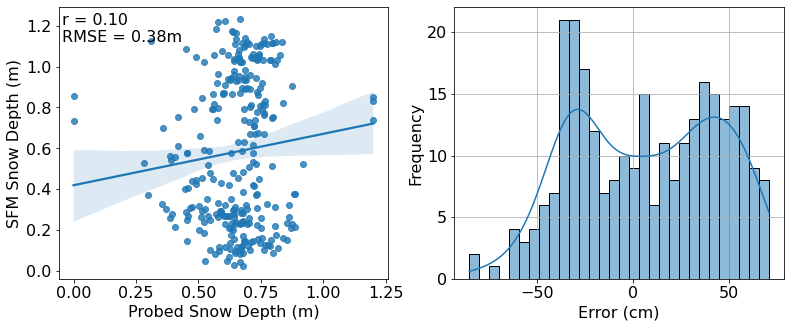

In [41]:
snowOnDEM_path = "/SNOWDATA/IDALS/2024/20231221/20231221_MCS_UAV/SfM/2023-12-22_MCS_DTM_UTM11N_0.5m_v2.tif"
snowFreeDEM_path = "/SNOWDATA/IDALS/misc_data_scripts/dem.tif"
veg_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/vh.tif"
vegMask_path = "/SNOWDATA/IDALS/misc_data_scripts/veg_mask.tif"
slope_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/slope.tif"
asp_path = "/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/topo_features/aspect.tif"
csv_path = "/SNOWDATA/IDALS/2024/20231221/20231221_SnowDepths/CR800Series_OperatorViewCSV_corrected.csv"
snowdepth_col = "DepthCm"
lat_col = "latitude(deg)"
lon_col = "longitude(deg)"

val_df3 = snowdepth_val3(snowOnDEM_path, snowFreeDEM_path, veg_path, vegMask_path, slope_path, asp_path, csv_path, snowdepth_col, lat_col, lon_col, csv_EPSG=4326, zone_utmcrs=32611, lid_unit="m", probe_unit="cm", veg_unit = "m", sd_f = 0.1)